<a target="_blank" href="https://colab.research.google.com/github/lukebarousse/Python_Data_Analytics_Course/blob/main/2_Advanced/11_Pandas_Explode.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Pandas Explode

Load data.

In [2]:
# Importing Libraries
import ast
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt  

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])

## Example

#### Why `df.explode()` is needed?

Here's a fake dataset of 3 job postings.

In [5]:
data = {
    'job_title_short': ['Data Analyst', 'Data Scientist', 'Data Engineer'],
    'job_skills': [['excel', 'sql', 'python'], ['python', 'r'], ['aws', 'python', 'airflow']]
}

df_skills = pd.DataFrame(data)

df_skills

,job_title_short,job_skills
0,Data Analyst,"[excel, sql, python]"
1,Data Scientist,"[python, r]"
2,Data Engineer,"[aws, python, airflow]"


If we wanted to analyze the skills in this we'd need a minimum of 5 lines of code to get the counts of skills.

In [6]:
df_skill_lists = df_skills.copy()

for row in df_skill_lists.itertuples():
    for skill in row.job_skills:
        df_skill_lists[skill] = df_skill_lists['job_skills'].apply(lambda x: skill in x)
        df_skill_lists[skill] = df_skill_lists[skill].astype(int)
        
df_skill_lists.loc['Total'] = df_skill_lists.sum()
    
df_skill_lists.iloc[:, 2:]

,excel,sql,python,r,aws,airflow
0,1,1,1,0,0,0
1,0,0,1,1,0,0
2,0,0,1,0,1,1
Total,1,1,3,1,1,1


However, exploding it out makes the data a lot easier to work with.

In [7]:
df_exploded = df_skills.explode('job_skills')

df_exploded

,job_title_short,job_skills
0,Data Analyst,excel
0,Data Analyst,sql
0,Data Analyst,python
1,Data Scientist,python
1,Data Scientist,r
2,Data Engineer,aws
2,Data Engineer,python
2,Data Engineer,airflow


Now we can perform value_counts and even plot it.

In [8]:
df_exploded.value_counts('job_skills')

job_skills
python     3
airflow    1
aws        1
excel      1
r          1
sql        1
Name: count, dtype: int64

<Axes: xlabel='job_skills'>

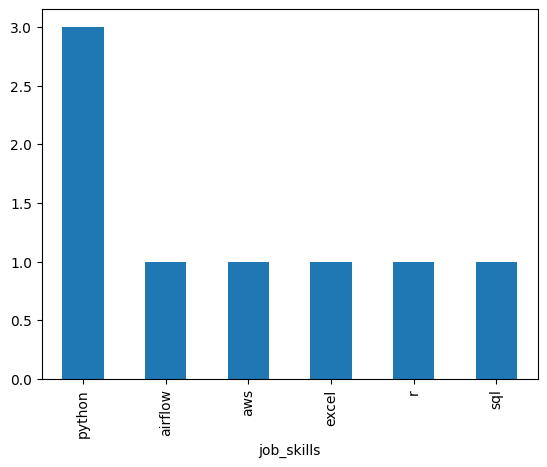

In [9]:
df_exploded.value_counts('job_skills').plot(kind='bar')

## Notes

* `explode()` - transforms each element of a list-like to a row
* Expand list-like data within a DataFrame column into separate rows. 
* Commonly used to split list data into individual rows for analysis (*hint* *hint*) or when working with JSON data in a DataFrame.

## Example

Let's transform the list like elements in the `job_skills` column to a row using the `explode()` function. This will make it so each skill will have its own row and we'll save this into a new DataFrame called `df_exploded`.

In the last section we already prepared our data and we converted our `job_skills` column to a list.

In [10]:
# Convert string representation to actual list, checking for NaN values first
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

df[['job_title_short', 'job_skills']].head(5)

,job_title_short,job_skills
0,Senior Data Engineer,None
1,Data Analyst,"[r, python, sql, nosql, power bi, tableau]"
2,Data Engineer,"[python, sql, c#, azure, airflow, dax, docker,..."
3,Data Engineer,"[python, c++, java, matlab, aws, tensorflow, k..."
4,Data Engineer,"[bash, python, oracle, aws, ansible, puppet, j..."


Now we're going to apply the `explode()` function onto each skill and make each skill have its own row.

In [11]:
# Explode 'job_skills' so each skill gets its own row
df_exploded = df.explode('job_skills')

Let's look at our new column.

In [12]:
df_exploded['job_skills']

0               None
1                  r
1             python
1                sql
1              nosql
             ...    
785739         kafka
785739    kubernetes
785739        docker
785740           aws
785740          flow
Name: job_skills, Length: 3777320, dtype: object

And now let's visualize it by getting the `value_counts()` of each skill.

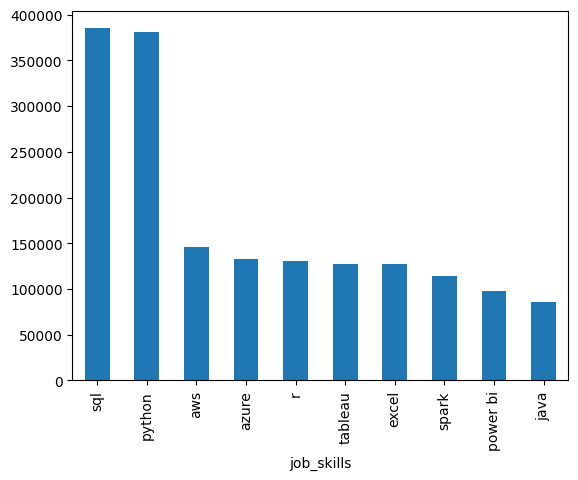

In [13]:
df_exploded['job_skills'].value_counts().head(10).plot(kind='bar')
plt.show()


### Calculate Skill Count

1. Then clean up the skills. We already did this in our last example.

In [15]:
# Explode job_skills column
df_skills = df_skills.explode('job_skills')
df_skills

,job_title_short,job_skills
0,Data Analyst,excel
0,Data Analyst,sql
0,Data Analyst,python
1,Data Scientist,python
1,Data Scientist,r
2,Data Engineer,aws
2,Data Engineer,python
2,Data Engineer,airflow


2. Now we'll calculate the skill count for each data job.

In [16]:
# Group by job_skills and job_title_short and count the number of occurrences
skills_count = df_skills.groupby(['job_skills', 'job_title_short']).size()

print('Type of skills_count: ', type(skills_count))
skills_count

Type of skills_count:  <class 'pandas.core.series.Series'>


job_skills  job_title_short
airflow     Data Engineer      1
aws         Data Engineer      1
excel       Data Analyst       1
python      Data Analyst       1
            Data Engineer      1
            Data Scientist     1
r           Data Scientist     1
sql         Data Analyst       1
dtype: int64

3. We'll `reset_index` to transform skills_count from a Series to a DataFrame.

In [17]:
# Name the count column as count
df_skills_count = skills_count.reset_index(name='skill_count') # we need to rename the main Series value to count

df_skills_count

,job_skills,job_title_short,skill_count
0,airflow,Data Engineer,1
1,aws,Data Engineer,1
2,excel,Data Analyst,1
3,python,Data Analyst,1
4,python,Data Engineer,1
5,python,Data Scientist,1
6,r,Data Scientist,1
7,sql,Data Analyst,1


4. We'll prep for plotting by the data getting in descending order.

In [18]:
df_skills_count.sort_values(by='skill_count',  inplace=True)

df_skills_count

,job_skills,job_title_short,skill_count
0,airflow,Data Engineer,1
1,aws,Data Engineer,1
2,excel,Data Analyst,1
3,python,Data Analyst,1
4,python,Data Engineer,1
5,python,Data Scientist,1
6,r,Data Scientist,1
7,sql,Data Analyst,1


5. Finally, we'll graph the top 10 skills using a bar chart.

In [19]:
job_title = 'Data Analyst'
head_value = 10

df_skill_final = df_skills_count[df_skills_count['job_title_short'] == job_title].head(head_value)

df_skill_final

,job_skills,job_title_short,skill_count
2,excel,Data Analyst,1
3,python,Data Analyst,1
7,sql,Data Analyst,1


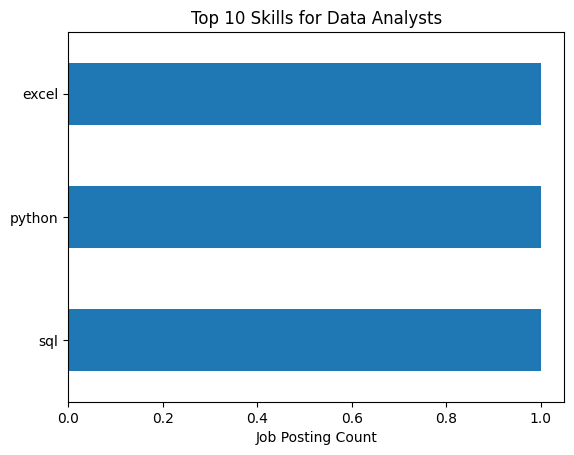

In [20]:
df_skill_final.plot(kind='barh', x='job_skills', y='skill_count')
plt.xlabel('Job Posting Count')
plt.ylabel('')
plt.title(f'Top {head_value} Skills for {job_title}s')
plt.gca().invert_yaxis()  # To display the highest value on top
plt.legend().set_visible(False)
plt.show()
